In [166]:
%%capture

!pip install ultralytics
!pip install shapely
!pip install python-dotenv
#install important packages

In [167]:
import os
from dotenv import load_dotenv
 
from ultralytics import YOLO

from matplotlib.pyplot import figure
from matplotlib import pyplot as plt

import numpy as np
from numpy import asarray
from PIL import Image, ImageDraw, ImageFont , ImageEnhance

import cv2

from shapely.geometry import Polygon
from inference_sdk import InferenceHTTPClient

from ChessTools import *
from computer_vision_tools import *


In [168]:
def order_points(pts):
    
    # order a list of 4 coordinates:
    # 0: top-left,
    # 1: top-right
    # 2: bottom-right,
    # 3: bottom-left
    
    if len(pts) < 4:
        raise ValueError("At least 4 points are required.")
    
    rect = np.zeros((4, 2), dtype = "float32")
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect




In [169]:
# calculates iou (intersection over union) between two polygons

def calculate_iou(box_1, box_2):
    poly_1 = Polygon(box_1)
    poly_2 = Polygon(box_2)
    iou = poly_1.intersection(poly_2).area / poly_1.union(poly_2).area
    return iou

In [170]:
def detect_corners_API(image_Path,confidence=50):
    
    load_dotenv()
    api_key = os.getenv('ROBOFLOW_API_KEY')

    image = Image.open(image_Path)
    CLIENT = InferenceHTTPClient(
        api_url="https://detect.roboflow.com",
        api_key=api_key
    )
    
    result = CLIENT.infer(image, model_id=f"chessboard-detection-yqcnu/3?confidence={confidence}")
        
    # Extracting the x, y coordinates of each corner
    corners = [[prediction['x'], prediction['y']] for prediction in result['predictions']]
    return np.array(corners, dtype="float32")

def detect_corners_local(image_Path,confidence=50):
    
    model = YOLO("../models/best_corner_detection_model.pt")
    
    
    # Run detection on the image
    results = model.predict(image_Path, conf=confidence/100)
    
    visualize_bounding_boxes(image_Path,results)

    #print(results)
    # Access the first element of the results list
    first_result = results[0]
    for detection in results[0].boxes:  # Access the first result and iterate over each detected box
        # Extract corner coordinates
        x1, y1, x2, y2 = detection.xyxy[0]  # Bounding box coordinates
        # Extract confidence score
        conf_score = detection.conf[0]
        # Extract class label
        class_label = detection.cls[0]

        #print(f"Corner detected at ({x1:.2f}, {y1:.2f}), ({x2:.2f}, {y2:.2f}) with confidence {conf_score:.2f} and label {class_label}")
        
    if first_result.boxes is not None:
        corners = [[(boxes[0] + boxes[2])/2,(boxes[1] + boxes[3])/2] for boxes in first_result.boxes.xyxy.cpu().numpy()]
        #print(corners)
        corners = corners[:4]
        
    else:
        corners = np.array([])  # If no corners are detected, return an empty array
    

    return np.array(corners, dtype="float32")


  

In [171]:

def visualize_bounding_boxes(image_path, detection_results, output_path="..\outputs\output_with_boxes.jpg"):
    """
    Visualize bounding boxes of detected corners on the image and save it in JPG format.

    Args:
        image_path (str): Path to the input image.
        detection_results: The results object from the YOLO model's prediction, containing bounding boxes.
        output_path (str): Path to save the output image with visualized bounding boxes in JPG format.
    """
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at path: {image_path}")

    # Iterate through bounding boxes and visualize them
    for box in detection_results[0].boxes[:4]:  # Access the first result
        x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())  # Extract bounding box coordinates
        confidence = box.conf[0]  # Confidence score
        label = int(box.cls[0])  # Class label (if applicable)

        # Draw a rectangle (bounding box)
        cv2.rectangle(image, (x1, y1), (x2, y2), color=(0, 0, 255), thickness=2)  # Green bounding box

        # Optionally, label the bounding box with class and confidence
        label_text = f"{label} ({confidence:.2f})"
        cv2.putText(image, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    # Save the output image explicitly in JPG format
    if not output_path.lower().endswith(".jpg"):
        output_path = output_path.rsplit('.', 1)[0] + ".jpg"
    cv2.imwrite(output_path, image, [cv2.IMWRITE_JPEG_QUALITY, 95])  # Save as JPG with quality setting
    print(f"Output image with bounding boxes saved at: {output_path}")



In [172]:
#perspective transforms an image with four given corners

def four_point_transform(image, pts,additional_height = 0):

    img = Image.open(image)
    #img.show()
    image = asarray(img)
    rect = order_points(pts)
    
    rect[0][1] = rect[0][1] - additional_height
    rect[1][1] = rect[1][1] - additional_height


    (tl, tr, br, bl) = rect

    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))


    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2)) 
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2)) 
    maxHeight = max(int(heightA), int(heightB))

    # construct set of destination points to obtain a "birds eye view"
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    img = Image.fromarray(warped, "RGB")
    #img.show()    
    # return the warped image
    img.save("../outputs/transformer_image.jpg")
    return img


In [173]:
# calculates chessboard grid

def plot_grid_on_transformed_image(image,additional_height = 0):
    
    corners = np.array([[0,0], 
                    [image.size[0], 0], 
                    [0, image.size[1]], 
                    [image.size[0], image.size[1]]])
    
    corners = order_points(corners)

    figure(figsize=(10, 10), dpi=80)

    # im = plt.imread(image)
    implot = plt.imshow(image)
    
    TL = corners[0]
    BL = corners[3]
    TR = corners[1]
    BR = corners[2]

    def interpolate(xy0, xy1):
        x0,y0 = xy0
        x1,y1 = xy1
        dx = (x1-x0) / 8
        dy = (y1-y0) / 8
        pts = [(x0+i*dx,y0+i*dy) for i in range(9)]
        return pts
    
    def interpolate_with_extra_height(xy0, xy1, height):
        x0,y0 = xy0
        x1,y1 = xy1
        dx = (x1-x0) / 8
        dy = (y1-height-y0) / 8
        pts = [(x0+i*dx,y0+i*dy + (i!=0)*height) for i in range(9)]
        return pts

    ptsT = interpolate( TL, TR )
    ptsL = interpolate_with_extra_height( TL, BL, additional_height )
    ptsR = interpolate_with_extra_height( TR, BR, additional_height )
    ptsB = interpolate( BL, BR )
        
    for a,b in zip(ptsL, ptsR):
        plt.plot( [a[0], b[0]], [a[1], b[1]], 'ro', linestyle="--" )
    for a,b in zip(ptsT, ptsB):
        plt.plot( [a[0], b[0]], [a[1], b[1]], 'ro', linestyle="--" )
        
    plt.axis('off')

    plt.savefig('../outputs/chessboard_transformed_with_grid.jpg')
    return ptsT, ptsL

In [174]:
# detects chess pieces

def chess_pieces_detector_API(image):
    
    # model_trained = YOLO("best_transformed_detection.pt")
    # results = model_trained.predict(source=image, line_thickness=1, conf=0.5, augment=False, save_txt=True, save=True)
    # 
    # print("results\n",results)
    # 
    # boxes = results[0].boxes
    # detections = boxes.xyxy.numpy()
    
    load_dotenv()
    api_key = os.getenv('ROBOFLOW_API_KEY')
    
    CLIENT = InferenceHTTPClient(
        api_url="https://detect.roboflow.com",
        api_key=api_key
    )
    
    result = CLIENT.infer(image, model_id="sp2-ym1iq-9on5y/1")
    
    boxes = [i["class_id"] for i in result["predictions"]]
    
    detections = [[i["x"]-i["width"]/2,i["y"]-i["height"]/2,i["x"]+i["width"]/2,i["y"]+i["height"]/2] for i in result["predictions"]]
    detections = np.array(detections,dtype="float32")
        
    return detections, boxes

def chess_pieces_detector_local(image,confidence = 50):
    
    model = YOLO("../models/best_chesspiece_model.pt")
    
    
    # Run detection on the image
    results = model.predict("../outputs/transformer_image.jpg", conf=confidence/100)
    
    visualize_chess_pieces("../outputs/transformer_image.jpg",results)
    # Access the first element of the results list
    first_result = results[0]
            
    boxes = [int(box.cls[0].item()) for box in first_result.boxes]
    detections = [box.xyxy[0].tolist() for box in first_result.boxes]

    return detections, boxes
    
    

In [175]:
import cv2
import numpy as np


def visualize_chess_pieces(image_path, detection_results, output_path="..\outputs\output_with_chess_pieces.jpg"):
    """
    Visualize bounding boxes for detected chess pieces with class names and colors.

    Args:
        image_path (str): Path to the input image.
        detection_results: The results object from the YOLO model's prediction, containing bounding boxes.
        output_path (str): Path to save the output image with visualized bounding boxes in JPG format.
    """
    # Define a color map for different chess piece classes
    CLASS_COLOR_MAP = {
        0: (0, 0, 255),    # Red - Black Bishop
        1: (0, 255, 0),    # Green - Black King
        2: (255, 0, 0),    # Blue - Black Knight
        3: (255, 255, 0),  # Cyan - Black Pawn
        4: (255, 0, 255),  # Magenta - Black Queen
        5: (0, 255, 255),  # Yellow - Black Rook
        6: (128, 0, 0),    # Dark Red - White Bishop
        7: (0, 128, 0),    # Dark Green - White King
        8: (0, 0, 128),    # Dark Blue - White Knight
        9: (128, 128, 0),  # Olive - White Pawn
        10: (128, 0, 128), # Purple - White Queen
        11: (0, 128, 128), # Teal - White Rook
    }
    
    CLASS_LABEL_MAP = {
        0: "Black Bishop",
        1: "Black King",
        2: "Black Knight",
        3: "Black Pawn",
        4: "Black Queen",
        5: "Black Rook",
        6: "White Bishop",
        7: "White King",
        8: "White Knight",
        9: "White Pawn",
        10: "White Queen",
        11: "White Rook",
    }
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at path: {image_path}")

    # Iterate through bounding boxes and visualize them
    for box in detection_results[0].boxes:  # Access the first result
        
        x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())  # Bounding box coordinates
        confidence = box.conf[0]  # Confidence score
        class_id = int(box.cls[0])  # Class ID

        # Get the color and label for the class
        color = CLASS_COLOR_MAP.get(class_id, (255, 255, 255))  # Default to white if class not found
        label = CLASS_LABEL_MAP.get(class_id, "Unknown")

        # Draw the bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), color=color, thickness=2)

        # Add class name and confidence score with larger text
        label_text = f"{label} ({confidence:.2f})"
        font_scale = 1.0  # Increased font scale for larger text
        thickness = 2     # Increased thickness for better visibility
        text_size = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)[0]
        text_x = x1
        text_y = max(y1 - 10, text_size[1] + 10)  # Ensure text is always visible

        # Background rectangle for text
        cv2.rectangle(image, (text_x, text_y - text_size[1] - 5), 
                      (text_x + text_size[0] + 5, text_y + 5), 
                      color, thickness=-1)  # Filled rectangle with the same color

        # Overlay text
        cv2.putText(image, label_text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 255, 255), thickness)

    # Save the output image explicitly in JPG format
    if not output_path.lower().endswith(".jpg"):
        output_path = output_path.rsplit('.', 1)[0] + ".jpg"
    cv2.imwrite(output_path, image, [cv2.IMWRITE_JPEG_QUALITY, 95])  # Save as JPG with quality setting
    print(f"Output image with chess piece borders saved at: {output_path}")


In [176]:
    
def connect_detection_to_square(squares,detection_box):
    list_of_iou = []
    
    box_x1 = detection_box[0]
    box_y1 = detection_box[1]

    box_x2 = detection_box[2]
    box_y2 = detection_box[1]

    box_x3 = detection_box[2]
    box_y3 = detection_box[3]

    box_x4 = detection_box[0]
    box_y4 = detection_box[3]
    
    #cut high pieces        
    if box_y4 - box_y1 > 60:
        box_complete = np.array([[box_x1,box_y1+40], [box_x2, box_y2+40], [box_x3, box_y3], [box_x4, box_y4]])
    else:
        box_complete = np.array([[box_x1,box_y1], [box_x2, box_y2], [box_x3, box_y3], [box_x4, box_y4]])
        
    for i in range (8):
        for j in range (8):
            list_of_iou.append(calculate_iou(box_complete, squares[i][j]))
    num = list_of_iou.index(max(list_of_iou))
    
    return num//8,num%8 #returns the position of the square that matches the piece detection the most

In [186]:
def FEN_transformation(ptsT,ptsL,detections,boxes):
        # Extract x-coordinates and y-coordinates from points
    x_coords = [pt[0] for pt in ptsT]
    y_coords = [pt[1] for pt in ptsL]

    # Initialize the FEN annotation grid
    FEN_annotation = []

    # Iterate to create grid squares
    for row in range(8):  # Rows 8 to 1
        current_row = []
        for col in range(8):  # Columns a to h
            square = np.array([
                [x_coords[col], y_coords[row + 1]],
                [x_coords[col + 1], y_coords[row + 1]],
                [x_coords[col + 1], y_coords[row]],
                [x_coords[col], y_coords[row]]
            ])
            current_row.append(square)
        FEN_annotation.append(current_row)

    board_FEN = [['1' for i in range(8)] for j in range(8)]
    
    di = {0: 'b', 1: 'k', 2: 'n',
      3: 'p', 4: 'q', 5: 'r', 
      6: 'B', 7: 'K', 8: 'N',
      9: 'P', 10: 'Q', 11: 'R'}
    
    for piece_number, detection_box in zip(boxes,detections):
        i, j = connect_detection_to_square(FEN_annotation,detection_box)
        board_FEN[i][j] = di[piece_number]
        
    print(board_FEN)
    complete_board_FEN = [''.join(line) for line in board_FEN] 
    return complete_board_FEN

In [187]:
def make_black_spots_blacker(image_path, output_path, threshold=50):
    """
    Enhances the black spots/pieces in the image by making them darker.
    
    Parameters:
    - image_path: Path to the input image.
    - output_path: Path to save the output image.
    - threshold: Grayscale intensity below which pixels are considered "dark" (0-255).
    """
    # Open the image
    img = Image.open(image_path).convert("RGB")
    
    # Convert to grayscale to identify dark areas
    grayscale = img.convert("L")
    
    # Create a mask for dark areas
    mask = grayscale.point(lambda p: 255 if p < threshold else 0, mode="1")
    
    # Darken the black spots
    darkened = img.point(lambda p: p * 0.5 if p < threshold else p)
    
    # Combine the darkened areas with the original image
    img = Image.composite(darkened, img, mask)
    
    # Save the modified image
    img.save(output_path)
    print(f"Image saved to {output_path}")

## Complete

[['r', 'n', 'k', '1', 'r', 'q', 'b', 'r'], ['p', 'p', 'p', 'p', 'p', 'p', 'p', 'p'], ['1', '1', '1', '1', '1', '1', '1', '1'], ['1', '1', '1', '1', '1', '1', '1', '1'], ['1', '1', '1', '1', '1', '1', '1', '1'], ['1', '1', '1', '1', '1', '1', '1', '1'], ['P', 'P', 'P', 'P', 'P', 'P', 'P', 'P'], ['R', 'N', 'B', 'Q', 'K', 'B', 'N', 'R']]
https://lichess.org/analysis/rnk1rqbr/pppppppp/11111111/11111111/11111111/11111111/PPPPPPPP/RNBQKBNR
rnk1rqbr/pppppppp/11111111/11111111/11111111/11111111/PPPPPPPP/RNBQKBNR
r n k . r q b r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R


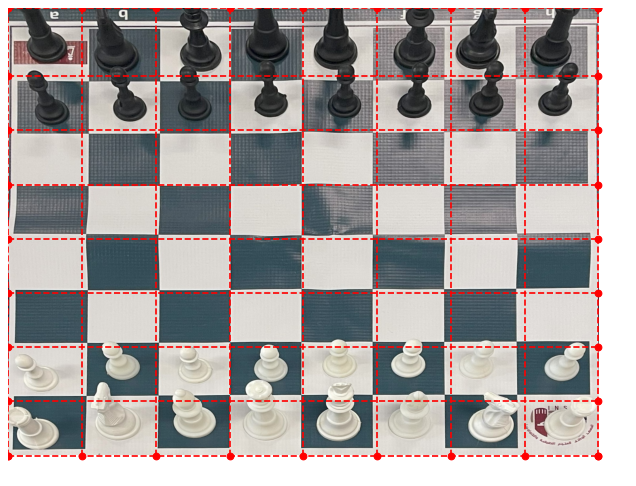

In [188]:

image_Path = '../images/image11.jpg'

#additionnal height is added based on the angle the picture was taken so that the top pieaces won't be cropped (height in pixels) 
additional_height = 50

corners = detect_corners_API(image_Path,9)

transformed_image = four_point_transform(image_Path, corners,additional_height)

ptsT, ptsL = plot_grid_on_transformed_image(transformed_image,additional_height)

detections, boxes = chess_pieces_detector_API(transformed_image)

complete_board_FEN = FEN_transformation(ptsT,ptsL,detections,boxes)

to_FEN = '/'.join(complete_board_FEN)

lichess_URL = "https://lichess.org/analysis/"+to_FEN

print(lichess_URL)

print(to_FEN)
print_board_from_fen(compress_fen(to_FEN))



image 1/1 C:\Users\rayen\PycharmProjects\ChessBotVision\notebooks\..\images\image11.jpg: 512x640 7 chess-table-cornerss, 74.2ms
Speed: 2.6ms preprocess, 74.2ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)
Output image with bounding boxes saved at: ..\outputs\output_with_boxes.jpg
Image saved to ../outputs/transformer_image.jpg
image 1/1 C:\Users\rayen\PycharmProjects\ChessBotVision\notebooks\..\outputs\transformer_image.jpg: 544x640 2 black-bishops, 1 black-king, 2 black-knights, 8 black-pawns, 2 black-queens, 2 black-rooks, 4 white-bishops, 2 white-knights, 8 white-pawns, 1 white-queen, 2 white-rooks, 86.4ms
Speed: 3.1ms preprocess, 86.4ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)
Output image with chess piece borders saved at: ..\outputs\output_with_chess_pieces.jpg
[['r', 'n', 'b', 'q', 'q', 'b', 'n', 'r'], ['p', 'p', 'p', 'p', 'p', 'p', 'p', 'p'], ['1', '1', '1', '1', '1', '1', '1', '1'], ['1', '1', '1', '1', '1', '1', '1', '1'], ['1', '1'

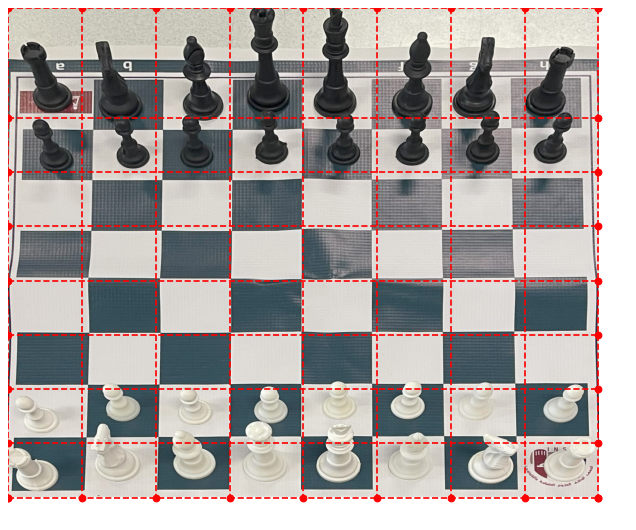

In [189]:
from tools.ChessTools import *

image_number = 11
image_Path = f'../images/image{image_number}.jpg'

#additionnal height is added based on the angle the picture was taken so that the top pieaces won't be cropped (height in pixels) 
additional_height = 200

corners = detect_corners_local(image_Path,confidence=9)

transformed_image = four_point_transform(image_Path, corners,additional_height)

ptsT, ptsL = plot_grid_on_transformed_image(transformed_image,additional_height)

#make_black_spots_blacker("../outputs/transformer_image.jpg","../outputs/transformer_image.jpg",80)

detections, boxes =chess_pieces_detector_local(transformed_image,40)

complete_board_FEN = FEN_transformation(ptsT,ptsL,detections,boxes)

to_FEN = '/'.join(complete_board_FEN)

lichess_URL = "https://lichess.org/analysis/"+to_FEN

print(lichess_URL)


print(to_FEN)
print_board_from_fen(compress_fen(to_FEN))


In [190]:
past_fen = "rnbqkbnr/pppppppp/11111111/11111111/11111111/11111111/PPPPPPPP/RNBQKBNR"
to_FEN = fix_queen_king_issue(past_fen,to_FEN)

print(to_FEN)
print_board_from_fen(compress_fen(to_FEN))

rnbqkbnr/pppppppp/11111111/11111111/11111111/11111111/PPPPPPPP/RNBQKBNR
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R
